# ADA Project Milestone P3

## <span style="color: blue;">As seasoned detectives, and to start our quest, we first need to gather all the information relevant to find the Bobos.</span>

## <span style="color: green;">To start our work, we first need to import libraries and set paths </span>

In [11]:
import os
import sys
import pickle
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import unidecode as ud
from tqdm import tqdm
from collections import Counter
from datetime import datetime
from matplotlib_venn import venn2

%matplotlib inline

from preprocessing_functions import *


### Set the global variables for the paths to the data folder

In [12]:
# add your data folder into the 'code' folder, make sure it is in the .gitignore file

CODE_DIR = os.getcwd()
DATA_DIR = os.path.join(CODE_DIR, 'data')

print('your data directory:', DATA_DIR)

# set path for BeerAdvocate data
DATA_BeerAdvocate = os.path.join(DATA_DIR, "BeerAdvocate.tar")

# set path for RateBeer data
DATA_RateBeer = os.path.join(DATA_DIR, "RateBeer.tar")

# set path for MatchedBeer data
DATA_MatchedBeers = os.path.join(DATA_DIR, "matched_beer_data.tar")

your data directory: c:\Users\fulci\git\ada_23\ada-2023-project-adarescueteam\code\data


## <span style="color: green;">Now we can begin: PART 0. Preproccesing and Data Cleaning</span>

We focus only on the ratings data, as it contains data with and without text, and the review is basically just a cleaner form of the ratings.

### <span style="color: green;">Read in and clean data </span> <span style="color: red;">(do not execute)</span>

#### Beeradvocate (BA) dataset

In [ ]:
# read in ratings.txt
BA_ratings = read_ratings_txt(DATA_BeerAdvocate, "ratings.txt")
# clean the missing unicodes
BA_ratings['text'] = unicode_conversion(BA_ratings['text'])
# temporarily save as csv
BA_ratings.to_csv(os.path.join(DATA_BeerAdvocate, "BA_ratings.csv"), index=False, encoding='utf-8')
# BeerAdvocate_ratings
with open(os.path.join(DATA_BeerAdvocate, "BA_ratings.pkl"), 'wb') as f:
    pickle.dump(BA_ratings, f)



#### Ratebeer (RB) dataset

In [ ]:
# read in ratings.txt
RB_ratings = read_ratings_txt(DATA_RateBeer, "ratings.txt") # has no 'review' column
# clean the missing unicodes
RB_ratings['text'] = unicode_conversion(RB_ratings['text'])
# temporarily save as csv
RB_ratings.to_csv(os.path.join(DATA_RateBeer, "RB_ratings.csv"), index=False, encoding='utf-8')
# RateBeer_ratings
with open(os.path.join(DATA_RateBeer, "RB_ratings.pkl"), 'wb') as f:
    pickle.dump(RB_ratings, f)

### <span style="color: green;">Create the glutenfree data </span>

##### Looking at what beers are gluten-free in RateBeer and BeerAdvocate

In [ ]:
rb_gf_beers=RB_beers[RB_beers['beer_name'].str.contains('gluten',case=False, na=False)]
rb_gf_beers_id=rb_gf_beers['beer_id']
print("Number of gluten-free beers in RateBeer:",rb_gf_beers.shape[0])

Number of gluten-free beers in RateBeer: 248


In [ ]:
ba_gf_beers=BA_beers[BA_beers['beer_name'].str.contains('gluten',case=False, na=False)]
ba_gf_beers_id=ba_gf_beers['beer_id']
print("Number of gluten-free beers in BeerAdvocate:",ba_gf_beers.shape[0])

Number of gluten-free beers in BeerAdvocate: 147


In [ ]:
#Number of coinciding beers between the two datasets:
coinciding_gf_beer=ba_gf_beers['beer_name'].isin(rb_gf_beers['beer_name'])
print('there are ', coinciding_gf_beer.sum(),' beers present in both dataset')
print('those beers are:','\n',ba_gf_beers[coinciding_gf_beer]['beer_name'].values)

there are  21  beers present in both dataset
those beers are: 
 ['Glutenberg 8' 'Glutenberg Cuvée Sauvage' 'Glutenberg Double Belge'
 'Glutenberg Double IPA' 'Glutenberg Gose'
 'Glutenberg Impérial Buchweizen' 'Glutenberg India Pale Ale'
 'Glutenberg Myrcène De Glace'
 'Glutenberg Myrcène De Glace (Brassin Spécial)' 'Drummond Gluten Free'
 'Nickel Brook Bull Eye Gluten Free Pale Ale'
 'Puerto Dorado Cerveza Sin Gluten' 'Riedenburger Gluten Frei'
 'Neumarkter Lammsbräu Glutenfrei' 'San Miguel Gluten Free'
 'Brok Gluten Free' 'Boxer Gluten Free' 'NGB Gluten Free Lager'
 'Portsmouth Gluten Minimus Saison' 'Brunehaut Bio Ambrée Gluten Free'
 'Slaapmutske Dubbel Glutenvrij']


##### Creation of review sub-dataset for only gluten-free beers

In [ ]:
rb_gf_ratings=RB_ratings[RB_ratings['beer_id'].isin(rb_gf_beers_id)]
rb_gf_ratings=rb_gf_ratings.merge(RB_users[['user_id','location']],on='user_id') #add location of users


For BeerAdvocate dataset, user_id are in form of "user_name.#someID", which creates problem when trying to merge on it, so we need to convert it to an actual numeric id. Here we will keep the id that is after the dot. This doesn't grant uniqueness of IDs, depleting the duplicates will

In [ ]:
import re

# leave only the numbers in the user_id column (else it wouldnt work)
BA_users['user_id'] = BA_users['user_id'].apply(lambda x: re.findall(r'\.(\d+)', x)[0]).astype(int)
BA_ratings['user_id'] = BA_ratings['user_id'].apply(lambda x: re.findall(r'\.(\d+)', x)[0]).astype(int)

duplicate_ba_id=BA_users[BA_users['user_id'].duplicated(keep='first')]['user_id']
BA_users=BA_users.drop(axis=0, index=duplicate_ba_id.index.values)
duplicate_ba_id_indexinratings= BA_ratings[BA_ratings['user_id'].isin(duplicate_ba_id)].index.values #get index of ratings placed by person with duplicate id
BA_ratings=BA_ratings.drop(axis=0,index=duplicate_ba_id_indexinratings)

ba_gf_ratings=BA_ratings[BA_ratings['beer_id'].isin(ba_gf_beers['beer_id'])]
ba_gf_ratings=ba_gf_ratings.merge(BA_users[['user_id','location']],on='user_id')

##### Change date to year only

Output of the timestamp function is not easily useable to look at evolution overtime. To change that, we will only look at the year of the ratings

In [ ]:
#if the data is read in only partially, for testing, we need to remove the NaNs
#RB_ratings.drop(RB_ratings.index[-1], inplace=True)
#BA_ratings.drop(BA_ratings.index[-1], inplace=True)

In [ ]:
BA_ratings['year']=BA_ratings['date'].apply(lambda x:int(x[:4])) #4 first characters of timestamp is the year the rating was posted
ba_gf_ratings['year']=ba_gf_ratings['date'].apply(lambda x:int(x[:4]))

RB_ratings['year']=RB_ratings['date'].apply(lambda x:int(x[:4])) #4 first characters of timestamp is the year the rating was posted
rb_gf_ratings['year']=rb_gf_ratings['date'].apply(lambda x:int(x[:4]))

In [ ]:
unicode_conversion(rb_gf_ratings['text'])
unicode_conversion(ba_gf_ratings['text'])

In [ ]:
rb_gf_ratings.to_csv((os.path.join(DATA_RateBeer, "rb_gf_ratings.csv")),index=False,header=True,encoding='utf-8')
ba_gf_ratings.to_csv((os.path.join(DATA_BeerAdvocate, "ba_gf_ratings.csv")),index=False,header=True,encoding='utf-8')

### <span style="color: green;">Load cleaned data </span>

#### RaterBeer (RB) Data

##### beers, breweries, users csv's

In [44]:
# read in the BeerAdvocate files
BA_beers = pd.read_csv(os.path.join(DATA_BeerAdvocate, "beers.csv"))
BA_breweries = pd.read_csv(os.path.join(DATA_BeerAdvocate, "breweries.csv"))
BA_users = pd.read_csv(os.path.join(DATA_BeerAdvocate, "users.csv"), 
                       converters={"joined": convert_timestamp})

##### ratings pickle

In [45]:
# read RB_ratings from pickle file
with open(os.path.join(DATA_RateBeer, "RB_ratings.pkl"), 'rb') as f:
    RB_ratings = pickle.load(f)


#### BeerAdvocate (BA) Data

##### beers, breweries, users csv's

In [46]:
# read in the RateBeer files
RB_beers = pd.read_csv(os.path.join(DATA_RateBeer, "beers.csv"))
RB_breweries = pd.read_csv(os.path.join(DATA_RateBeer, "breweries.csv"))
RB_users = pd.read_csv(os.path.join(DATA_RateBeer, "users.csv"),
                       converters={"joined": convert_timestamp})

##### ratings pickle

In [47]:
# read BA_ratings from pickle file
with open(os.path.join(DATA_BeerAdvocate, "BA_ratings.pkl"), 'rb') as f:
    BA_ratings = pickle.load(f)

In [48]:
# the review column needs to be formatted correctly
# show true and false values in BA_ratings['review']
var = BA_ratings['review'].unique()

# replace the true and false values in BA_ratings['review'] with True and False
BA_ratings['review'] = BA_ratings['review'].replace(var[0], True)
BA_ratings['review'] = BA_ratings['review'].replace(var[1], False)

(BA_ratings['review']).dtypes


dtype('bool')

In [49]:
# and also distinguish the two datasets BA and RB ratings
BA_ratings['dataset'] = 'BA'
RB_ratings['dataset'] = 'RB'

#### Glutenfree (gf) Beer Data

In [50]:
# read in the glutenfree beers
rb_gf_ratings=pd.read_csv(os.path.join(DATA_RateBeer, 'rb_gf_ratings.csv'), low_memory=False, encoding='utf-8')
ba_gf_ratings=pd.read_csv(os.path.join(DATA_BeerAdvocate, 'ba_gf_ratings.csv'), low_memory=False, encoding='utf-8')
rb_gf_ratings.shape, ba_gf_ratings.shape

((3770, 18), (2397, 19))

In [51]:
# add the review columns to the rb_gf_ratings
rb_gf_ratings['review'] = True

In [52]:
# merge the two datasets
gf_ratings = pd.concat([rb_gf_ratings, ba_gf_ratings])
gf_ratings.shape

(6167, 19)

In [53]:
# check duplicates
gf_ratings.duplicated().sum()

0

## <span style="color: green;">We got intel that the Bobo's stronghold resides in the Gluten Free datasets. So to perceive their potential threat, we must match the normal and the Gluten Free datasets. </span>

### Before that, we need to filter the data for matching.

#### Filter by style

In this section, we want to match the glutenfree (gf) beers by style with the conventional beers. For this we can remove all the style in the BA or RB dataset, which is not represented in the gf beer dataset.

Following this, we merge the two _style datasets and check for duplicates.

### Glutenfree

In [54]:
#Keep only beer-types present in gluten-free beers

gf_beers=gf_ratings['beer_name'].unique()

for i in range(len(gf_beers)): #Somehow there is a space at beginning of beer_names
    gf_beers[i]=gf_beers[i][1:]

BA_gf_beertypes = BA_beers[BA_beers['beer_name'].isin(gf_beers)]['style'].unique()
RB_gf_beertypes = RB_beers[RB_beers['beer_name'].isin(gf_beers)]['style'].unique()

In [55]:
gf_beertypes = np.concatenate((BA_gf_beertypes,RB_gf_beertypes))
gf_beertypes=pd.DataFrame(gf_beertypes,columns=['style'])
gf_beertypes=gf_beertypes['style'].unique()

In [56]:
# represent only the styles in the full dataset that are also represented in the glutenfree dataset
# Here we do the comparison by first extracting the beer_id with the beer style from the datasets, as there is issues comparing directly the array gf_beertypes

# for BeerAdvocate 
BA_beers[BA_beers['style'].isin(gf_beertypes)]  # 169793 rows
BA_beerID_style = BA_beers[BA_beers['style'].isin(gf_beertypes)][['beer_id', 'style']]
BA_ratings_style = BA_ratings[BA_ratings['beer_id'].isin(BA_beerID_style['beer_id'])]

# and the same for Ratebeer
RB_beers[RB_beers['style'].isin(gf_beertypes)]
RB_beerID_style = RB_beers[RB_beers['style'].isin(gf_beertypes)][['beer_id', 'style']]
RB_ratings_style = RB_ratings[RB_ratings['beer_id'].isin(RB_beerID_style['beer_id'])]

In [57]:
# merge this two dataframes
    # beforehands, we add a review column to avoid nan conflicts later
RB_ratings_style['review'] = True

ratings_style = pd.concat([BA_ratings_style, RB_ratings_style])
ratings_style.shape 

C:\Users\fulci\AppData\Local\Temp\ipykernel_30448\280952039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RB_ratings_style['review'] = True


(9371934, 18)

In [59]:
# check for duplicates
# ratings_style.duplicated().sum()

12

In [60]:
# remove all duplicates and check again
ratings_style = ratings_style[~ratings_style.duplicated(keep='first')]
ratings_style.duplicated().sum()

0

We want to make sure that the glutenfree beers are not contained in the full data, especially because not subtracting the gf data would produce duplicates in the analysis and thus unwanted perfect matchings between the same samples.

In [61]:
# merge the two dfs and only keep the rows that are present in ratings_style but not in gf_ratings (delete all gf rows from ratings_style)
merged_ratings = pd.merge(ratings_style, gf_ratings, indicator=True, how='outer')
ratings_style = merged_ratings[merged_ratings['_merge'] == 'left_only'].drop(columns=['_merge', 'location', 'year'])
ratings_style

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,dataset
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True,BA
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.0,3.5,3.5,4.0,3.5,3.67,Pours pale copper with a thin head that quick...,True,BA
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.0,3.5,3.5,4.0,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....",True,BA
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.0,3.5,4.0,4.0,4.5,3.98,Serving: 500ml brown bottlePour: Good head wi...,True,BA
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.0,4.0,4.0,4.0,4.0,4.00,"500ml bottlePours with a light, slightly hazy...",True,BA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9371917,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2014-09-18 10:00:00,Travlr,83882,3,6,2,5,10,2.60,"Draft at the source. Clear golden color, fluf...",True,RB
9371918,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2013-12-01 11:00:00,TBone,10233,2,5,2,6,10,2.50,"Tap @brewpub, TiraneClear golden color, good ...",True,RB
9371919,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-11-04 11:00:00,Rob_D_UK,257161,3,4,2,5,9,2.30,In their beer garden after a walking tour aro...,True,RB
9371920,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-09-16 10:00:00,Travlr,83882,3,5,1,4,6,1.90,"Draft at the source. Hazy maroon color, tan h...",True,RB


Now let's prepare the dataset for the third question which looks at the reviews, we filter out the samples that have no review and create **reviews_style**

In [62]:
(ratings_style['review']!=True).sum()

3423303

In [63]:
reviews_style = ratings_style[(ratings_style['review'] == True)]
reviews_style.shape

(5944849, 18)

In [65]:
# save as pickle 
#with open(os.path.join(DATA_DIR, "reviews_style.pkl"), 'wb') as f:
#    pickle.dump(reviews_style, f)

##### Load the reviews by style from pickle

In [4]:
with open(os.path.join(DATA_DIR, "reviews_style.pkl"), 'rb') as f:
    reviews_style = pickle.load(f)

In [66]:
with open(os.path.join(DATA_DIR, "BA_reviews_style.pkl"), 'rb') as f:
    BA_reviews_style = pickle.load(f)

Finally, we only want to focus on the reviews that are either english or french, thus we remove all languages that we are not interested in.

In [34]:
# plit the dataframe the more efficient way..

parts = 7
length = (len(reviews_style) // parts) + 1
split_reviews = []
for i in range(parts):
    start_idx = i * length
    end_idx = min((i + 1) * length, len(reviews_style))
    split_reviews.append(reviews_style.iloc[start_idx:end_idx, :])
reviews_style_1, reviews_style_2, reviews_style_3, reviews_style_4, reviews_style_5, reviews_style_6, reviews_style_7 = split_reviews #call parts either with split_reviews[0] or reviews_style_xy

# put this function into 'filtering' auxiliary function

In [27]:
# save as pickle
#with open(os.path.join(DATA_DIR, "split_reviews.pkl"), 'wb') as f:
#    pickle.dump(split_reviews, f)

##### Load the split reviews from pickle

In [3]:
with open(os.path.join(DATA_DIR, "split_reviews.pkl"), 'rb') as f:
    split_reviews = pickle.load(f)

reviews_style_1, reviews_style_2, reviews_style_3, reviews_style_4, reviews_style_5, reviews_style_6, reviews_style_7 = split_reviews #call parts either with split_reviews[0] or reviews_style_xy


### <span style="color: red;">For our quest, and to more easily highlight the Bobos, we need to detect what they have to say on the Beers. This basically implies that we need to analyse the beer reviews.</span>

### <span style="color: red;">We start our textual analysis by a general EDA to detect the languages that are present in the dataset</span>

### <span style="color: red;">Hence we start! Part 1:Language processing</span>

#### 1.1 Language identification

In [8]:
# import torch                  # if you run spacy, don run torch
# torch.cuda.is_available()
# !pip install spacy-transformers
# !python -m pip install --default-timeout=1000 spacy
!python -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.7.2                         
Location         c:\Users\fulci\anaconda3\Lib\site-packages\spacy
Platform         Windows-10-10.0.22631-SP0     
Python version   3.11.5                        
Pipelines        en_core_web_sm (3.7.1), en_core_web_trf (3.7.3)



In [4]:
import cupy #GPU support        (dont use if not using the gpu)

In [ ]:
'''General function to detect the languages'''
import spacy
import spacy_transformers
from spacy.language import Language
from spacy_langdetect import LanguageDetector

def get_lang_detector(nlp, name):
    return LanguageDetector()

#spacy.require_gpu(), spacy.prefer_gpu()


In [ ]:
'''We now define the model's pipeline'''
nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load("en_core_web_trf")    # works less good than _sm
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [7]:
'''Add the detected languages'''
reviews_languages = []

for row in tqdm(range(len(reviews_style_2))):
    try:
        doc = nlp(reviews_style_2['text'].iloc[row])
        reviews_languages.append(doc._.language['language'])
    except Exception as e:
        reviews_languages.append(np.nan)

100%|██████████| 651135/651135 [2:52:45<00:00, 62.82it/s]  


In [47]:
reviews_style_2['lang'] = reviews_languages
reviews_style_2[reviews_style_2['lang'].isna()].head() # strange that the data is not filtered out

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
5470396,Holsten Premium Bier,3101,Holsten-Brauerei &#40;Carlsberg&#41;,540,Premium Lager,5.0,2004-05-21 10:00:00,miko,12525,3,7,3,7,16,3.6,NaN,True,NaN
5479207,Augustiner Weissbier,10130,Augustiner-Bräu,777,German Hefeweizen,5.4,2009-01-18 11:00:00,Grossecaisse,74904,3,5,3,4,10,2.5,NaN,True,NaN
5481806,Weihenstephaner Hefeweissbier,1156,Bayerische Staatsbrauerei Weihenstephan,282,German Hefeweizen,5.4,2009-01-20 11:00:00,Grossecaisse,74904,3,6,3,6,12,3.0,NaN,True,NaN
5487155,Ayinger Altbairisch Dunkel,2019,Brauerei Aying,176,Dunkel/Tmavý,5.0,2009-01-20 11:00:00,Grossecaisse,74904,4,8,4,8,16,4.0,NaN,True,NaN
5491779,Weltenburger Hefe-Weißbier Hell,82447,Brauerei Bischofshof,2015,German Hefeweizen,5.4,2009-01-20 11:00:00,Grossecaisse,74904,3,6,3,6,12,3.0,NaN,True,NaN


should have been filtered out... will sort out at the end

In [9]:
# save as pickle
#with open(os.path.join(DATA_DIR, "reviews_style_2.pkl"), 'wb') as f:
#    pickle.dump(reviews_style_2, f)

Put the snippets with the lang column together

In [27]:
# read all splits into a dataframes dictionary to concatenate in the next step

dataframes = {}  # Dictionary to store DataFrames

for i in range(1, 8):
    filename = f"reviews_style_lang_{i}.pkl"
    filepath = os.path.join(DATA_DIR, filename)

    # Load data from the pickle file
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
        df = pd.DataFrame(data)  # Assuming the loaded data is in a suitable format for DataFrame creation
        dataframes[f"reviews_style_lang_{i}"] = df

In [29]:
reviews_style_lang = pd.concat(dataframes.values(), ignore_index=True)
reviews_style_lang

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozł...",True,pl
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. Más floja que la...,True,es
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średn...",True,pl
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.5,"Botella, de Gabón regalo familiar.31/01/2015C...",True,es
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4557939,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2014-09-18 10:00:00,Travlr,83882,3,6,2,5,10,2.6,"Draft at the source. Clear golden color, fluf...",True,NaN
4557940,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2013-12-01 11:00:00,TBone,10233,2,5,2,6,10,2.5,"Tap @brewpub, TiraneClear golden color, good ...",True,NaN
4557941,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-11-04 11:00:00,Rob_D_UK,257161,3,4,2,5,9,2.3,In their beer garden after a walking tour aro...,True,NaN
4557942,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-09-16 10:00:00,Travlr,83882,3,5,1,4,6,1.9,"Draft at the source. Hazy maroon color, tan h...",True,NaN


remove all Nan columns and filter all the english and french out

In [38]:
# show only the reviews which have a text (272 turn out to have nan)
reviews_style_lang.loc[~reviews_style_lang['text'].isna()]

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozł...",True,pl
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. Más floja que la...,True,es
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średn...",True,pl
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.5,"Botella, de Gabón regalo familiar.31/01/2015C...",True,es
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4557939,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2014-09-18 10:00:00,Travlr,83882,3,6,2,5,10,2.6,"Draft at the source. Clear golden color, fluf...",True,NaN
4557940,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,nan,2013-12-01 11:00:00,TBone,10233,2,5,2,6,10,2.5,"Tap @brewpub, TiraneClear golden color, good ...",True,NaN
4557941,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-11-04 11:00:00,Rob_D_UK,257161,3,4,2,5,9,2.3,In their beer garden after a walking tour aro...,True,NaN
4557942,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,nan,2014-09-16 10:00:00,Travlr,83882,3,5,1,4,6,1.9,"Draft at the source. Hazy maroon color, tan h...",True,NaN


In [37]:
# so much text that couldnt be quantified...
reviews_style_lang['lang'].isna().sum()

##### not removing for now.. plan could be to filter them out and retry to run the nlp... although i think the problem is because of floats in the text (run the nlp pipeline without 'try:' ... 'except: na...')

1302406

In [39]:
# save review_style_lang pickle
#with open(os.path.join(DATA_DIR, "reviews_style_lang.pkl"), 'wb') as f:
#    pickle.dump(reviews_style_lang, f)

In [8]:
# load the pickle with reviews sorted by style and with the language column
with open(os.path.join(DATA_DIR, "reviews_style_lang.pkl"), 'rb') as f:
    reviews_style_lang = pickle.load(f)

In [9]:
reviews_style_lang_en_fr = reviews_style_lang[reviews_style_lang['lang'].isin(['en', 'fr'])]
reviews_style_lang_en_fr

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en
5,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-12 10:00:00,Beerhunter111,227834,2,3,2,3,9,1.9,Many thanks to Erzengel for sharing! Pours cl...,True,en
6,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-07 10:00:00,Erzengel,83106,4,5,4,5,8,2.6,Many thanks to Travlr for this can! Grainy n...,True,en
8,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2014-05-29 10:00:00,Lowenbrau,37316,3,5,2,3,7,2.0,"330ml bottle. 29-05-2014.From Gabon, courtesy...",True,en
9,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2013-07-18 10:00:00,seynie,75452,2,3,3,4,6,1.8,Light yellow with quickly disappearing foam t...,True,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255670,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-12 11:00:00,czar,104498,3,8,3,7,14,3.5,"bottle shared by tom10101, thanks bro. pours ...",True,en
3255671,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-11 11:00:00,DCLawyer,221043,4,7,4,6,16,3.7,Bottle->tulip. Very cloudy orange with frothy...,True,en
3255672,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-08 11:00:00,jtclockwork,104199,4,7,3,7,14,3.5,Bottle. Pours amber peach with white head. No...,True,en
3255673,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-03 11:00:00,RamyG4,79534,5,9,4,8,14,4.0,Bottle. Mostly opaque golden beer with a medi...,True,en


Do it for the glutenfree beers as well

In [13]:
gf_reviews = gf_ratings[gf_ratings['review']==True]

In [22]:
gf_reviews_languages = []

for row in tqdm(range(len(gf_reviews))):
    try:
        doc = nlp(gf_reviews['text'].iloc[row])
        gf_reviews_languages.append(doc._.language['language'])
    except Exception as e:
        gf_reviews_languages.append(np.nan)

100%|██████████| 3770/3770 [01:04<00:00, 58.41it/s]


In [23]:
gf_reviews['lang'] = gf_reviews_languages
gf_reviews[gf_reviews['lang'].isna()]#.head() # strange that the data is not filtered out

C:\Users\fulci\AppData\Local\Temp\ipykernel_32604\2879938099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_reviews['lang'] = gf_reviews_languages


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,location,year,review,lang


In [24]:
gf_reviews

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,location,year,review,lang
0,Kowloon Bay Gluten Free IPA,436710,Kowloon Bay Brewery,25260,India Pale Ale (IPA),6.6,2016-07-26 10:00:00,CacheManyHose,282160,3,7,2,6,14,3.2,Drank at Home: Eat To Live cafe. Floral hop n...,Hong Kong,2016,True,en
1,Glutenberg 1er Anniversaire,182791,Glutenberg Brewing Company,13241,Specialty Grain,7.5,2013-07-14 10:00:00,BiereLuc,131174,3,7,3,8,16,3.7,Bière cuivrée. Nez houblon-caramel. En bouche...,Canada,2013,True,fr
2,Glutenberg 8,162109,Glutenberg Brewing Company,13241,Specialty Grain,5.0,2014-10-04 10:00:00,BiereLuc,131174,3,7,2,7,15,3.4,"En fouillant dans mes carnets, je suis retomb...",Canada,2014,True,fr
3,Glutenberg Belge de Saison 2013,204934,Glutenberg Brewing Company,13241,Saison,7.0,2013-02-21 11:00:00,BiereLuc,131174,3,8,3,8,18,4.0,"(Version 2013, recette différente) - Belle co...",Canada,2013,True,fr
4,Glutenberg Belge de Saison 2014,253815,Glutenberg Brewing Company,13241,Saison,7.0,2014-04-22 10:00:00,BiereLuc,131174,3,6,3,7,15,3.4,"Bière couleur paille, limpide et mousseuse. L...",Canada,2014,True,fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,Grain dOrge Glutenfri Ekologisk Ale,475575,Grain dOrge (Brasseurs De Gayant),759,Golden Ale/Blond Ale,3.5,2017-07-24 10:00:00,Samuel214,381941,3,5,2,4,6,2.0,"Flaska från Coop Konsum. Kristallklar, ljus b...",Sweden,2017,True,sv
3766,Grain dOrge Glutenfri Ekologisk Ale,475575,Grain dOrge (Brasseurs De Gayant),759,Golden Ale/Blond Ale,3.5,2017-05-27 10:00:00,Pilsnertest,385469,3,3,1,3,6,1.6,"Can at home. Taste of paper, hay, boiled vege...",Sweden,2017,True,en
3767,Grain dOrge Glutenfri Ekologisk Ale,475575,Grain dOrge (Brasseurs De Gayant),759,Golden Ale/Blond Ale,3.5,2017-05-05 10:00:00,elosop,148291,4,5,3,7,10,2.9,Halmgul med tunt vitt skum. Doftar kryddor oc...,Sweden,2017,True,sv
3768,Grain dOrge Glutenfri Ekologisk Lager,477827,Grain dOrge (Brasseurs De Gayant),759,Pale Lager,3.5,2017-01-07 11:00:00,Malin_aiisa,361626,2,6,3,5,11,2.7,"Bottle. Pours clear amber, no head. Aroma mal...",Sweden,2017,True,en


In [25]:
gf_reviews_lang_en_fr = gf_reviews[gf_reviews['lang'].isin(['en', 'fr'])]
gf_reviews_lang_en_fr

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,location,year,review,lang
0,Kowloon Bay Gluten Free IPA,436710,Kowloon Bay Brewery,25260,India Pale Ale (IPA),6.6,2016-07-26 10:00:00,CacheManyHose,282160,3,7,2,6,14,3.2,Drank at Home: Eat To Live cafe. Floral hop n...,Hong Kong,2016,True,en
1,Glutenberg 1er Anniversaire,182791,Glutenberg Brewing Company,13241,Specialty Grain,7.5,2013-07-14 10:00:00,BiereLuc,131174,3,7,3,8,16,3.7,Bière cuivrée. Nez houblon-caramel. En bouche...,Canada,2013,True,fr
2,Glutenberg 8,162109,Glutenberg Brewing Company,13241,Specialty Grain,5.0,2014-10-04 10:00:00,BiereLuc,131174,3,7,2,7,15,3.4,"En fouillant dans mes carnets, je suis retomb...",Canada,2014,True,fr
3,Glutenberg Belge de Saison 2013,204934,Glutenberg Brewing Company,13241,Saison,7.0,2013-02-21 11:00:00,BiereLuc,131174,3,8,3,8,18,4.0,"(Version 2013, recette différente) - Belle co...",Canada,2013,True,fr
4,Glutenberg Belge de Saison 2014,253815,Glutenberg Brewing Company,13241,Saison,7.0,2014-04-22 10:00:00,BiereLuc,131174,3,6,3,7,15,3.4,"Bière couleur paille, limpide et mousseuse. L...",Canada,2014,True,fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,Grain dOrge Sans Gluten Bio (Gluten Free / G...,328974,Brasserie Goudale (Saint-Omer),29110,Golden Ale/Blond Ale,5.5,2015-04-24 10:00:00,larsniclas,6693,2,5,3,6,12,2.8,Bottled from Ica à keredClear golden with a b...,Sweden,2015,True,en
3763,Castelain Jade Sans Gluten,381938,Castelain,739,Pale Lager,4.5,2017-07-18 10:00:00,PapaCanard,393710,3,6,3,4,10,2.6,Une bière sans gluten! Il lui manque ce qui e...,Switzerland,2017,True,fr
3766,Grain dOrge Glutenfri Ekologisk Ale,475575,Grain dOrge (Brasseurs De Gayant),759,Golden Ale/Blond Ale,3.5,2017-05-27 10:00:00,Pilsnertest,385469,3,3,1,3,6,1.6,"Can at home. Taste of paper, hay, boiled vege...",Sweden,2017,True,en
3768,Grain dOrge Glutenfri Ekologisk Lager,477827,Grain dOrge (Brasseurs De Gayant),759,Pale Lager,3.5,2017-01-07 11:00:00,Malin_aiisa,361626,2,6,3,5,11,2.7,"Bottle. Pours clear amber, no head. Aroma mal...",Sweden,2017,True,en


In [27]:
# merge the gf_reviews and reviews _lang_en_fr
# but first add a column 'glutenfree' to both datasets to distinguish them
gf_reviews_lang_en_fr['glutenfree'] = True
reviews_style_lang_en_fr['glutenfree'] = False

C:\Users\fulci\AppData\Local\Temp\ipykernel_32604\1875674314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_reviews_lang_en_fr['glutenfree'] = True
C:\Users\fulci\AppData\Local\Temp\ipykernel_32604\1875674314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_style_lang_en_fr['glutenfree'] = False


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang,glutenfree
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours ...,True,en,False
5,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-12 10:00:00,Beerhunter111,227834,2,3,2,3,9,1.9,Many thanks to Erzengel for sharing! Pours cl...,True,en,False
6,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-07 10:00:00,Erzengel,83106,4,5,4,5,8,2.6,Many thanks to Travlr for this can! Grainy n...,True,en,False
8,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2014-05-29 10:00:00,Lowenbrau,37316,3,5,2,3,7,2.0,"330ml bottle. 29-05-2014.From Gabon, courtesy...",True,en,False
9,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2013-07-18 10:00:00,seynie,75452,2,3,3,4,6,1.8,Light yellow with quickly disappearing foam t...,True,en,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255670,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-12 11:00:00,czar,104498,3,8,3,7,14,3.5,"bottle shared by tom10101, thanks bro. pours ...",True,en,False
3255671,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-11 11:00:00,DCLawyer,221043,4,7,4,6,16,3.7,Bottle->tulip. Very cloudy orange with frothy...,True,en,False
3255672,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-08 11:00:00,jtclockwork,104199,4,7,3,7,14,3.5,Bottle. Pours amber peach with white head. No...,True,en,False
3255673,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-03 11:00:00,RamyG4,79534,5,9,4,8,14,4.0,Bottle. Mostly opaque golden beer with a medi...,True,en,False


In [29]:
reviews_en_fr = pd.concat([gf_reviews_lang_en_fr, reviews_style_lang_en_fr])
reviews_en_fr

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,text,location,year,review,lang,glutenfree
0,Kowloon Bay Gluten Free IPA,436710,Kowloon Bay Brewery,25260,India Pale Ale (IPA),6.6,2016-07-26 10:00:00,CacheManyHose,282160,3,...,2,6,14,3.2,Drank at Home: Eat To Live cafe. Floral hop n...,Hong Kong,2016.0,True,en,True
1,Glutenberg 1er Anniversaire,182791,Glutenberg Brewing Company,13241,Specialty Grain,7.5,2013-07-14 10:00:00,BiereLuc,131174,3,...,3,8,16,3.7,Bière cuivrée. Nez houblon-caramel. En bouche...,Canada,2013.0,True,fr,True
2,Glutenberg 8,162109,Glutenberg Brewing Company,13241,Specialty Grain,5.0,2014-10-04 10:00:00,BiereLuc,131174,3,...,2,7,15,3.4,"En fouillant dans mes carnets, je suis retomb...",Canada,2014.0,True,fr,True
3,Glutenberg Belge de Saison 2013,204934,Glutenberg Brewing Company,13241,Saison,7.0,2013-02-21 11:00:00,BiereLuc,131174,3,...,3,8,18,4.0,"(Version 2013, recette différente) - Belle co...",Canada,2013.0,True,fr,True
4,Glutenberg Belge de Saison 2014,253815,Glutenberg Brewing Company,13241,Saison,7.0,2014-04-22 10:00:00,BiereLuc,131174,3,...,3,7,15,3.4,"Bière couleur paille, limpide et mousseuse. L...",Canada,2014.0,True,fr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255670,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-12 11:00:00,czar,104498,3,...,3,7,14,3.5,"bottle shared by tom10101, thanks bro. pours ...",NaN,NaN,True,en,False
3255671,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-11 11:00:00,DCLawyer,221043,4,...,4,6,16,3.7,Bottle->tulip. Very cloudy orange with frothy...,NaN,NaN,True,en,False
3255672,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-08 11:00:00,jtclockwork,104199,4,...,3,7,14,3.5,Bottle. Pours amber peach with white head. No...,NaN,NaN,True,en,False
3255673,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-03 11:00:00,RamyG4,79534,5,...,4,8,14,4.0,Bottle. Mostly opaque golden beer with a medi...,NaN,NaN,True,en,False


location and year missing in the reviews from non-glutenfree.. need a fix here

In [30]:
# save reviews_en_fr pickle
with open(os.path.join(DATA_DIR, "reviews_en_fr.pkl"), 'wb') as f:
    pickle.dump(reviews_en_fr, f)

Load the pickle for reviews_en_fr

In [31]:
with open(os.path.join(DATA_DIR, "reviews_en_fr.pkl"), 'rb') as f:
    reviews_en_fr = pickle.load(f)

In [34]:
reviews_en_fr['lang'].unique()

array(['en', 'fr'], dtype=object)

### (START FROM HERE AS YOU DOWNLOAD THE LATEST PKL FILES)
### Reload and complete the dataset

So far we obtained two major dataset:
- `review_style_lang` which contains the reviews for all beers annotated by languange, filtered by style.
- `review_en_fr` which contains the reviews for beers with english or french reviews, filtered by style, annotated by language and glutenfree status.

In [14]:
# read in the dataset that is preprocessed with beer styles and language    
with open(os.path.join(DATA_DIR, "reviews_style_lang.pkl"), 'rb') as f:
    reviews_style_lang = pickle.load(f)


In [15]:
with open(os.path.join(DATA_DIR, "reviews_en_fr.pkl"), 'rb') as f:
    reviews_en_fr = pickle.load(f)

### Complete the 'year' column

In non-glutenfree reviews, the year data is missing. We complete the column by extracting the corresponding information from the 'date' column.

In [16]:
# format 2016-04-26 10:00:00
reviews_style_lang['year'] = reviews_style_lang['date'].str.split('-').str[0].astype(int)
reviews_en_fr['year'] = reviews_en_fr['date'].str.split('-').str[0].astype(int)

### Complete the 'location' column

In [17]:
# if location column exists, drop it
if 'location' in reviews_style_lang.columns:
    reviews_style_lang.drop('location', axis=1, inplace=True)
if 'location' in reviews_en_fr.columns:
    reviews_en_fr.drop('location', axis=1, inplace=True)
reviews_style_lang = reviews_style_lang.merge(RB_users[['user_id', 'location']], on='user_id', how='left')
reviews_en_fr = reviews_en_fr.merge(RB_users[['user_id', 'location']], on='user_id', how='left')

### Beer style check

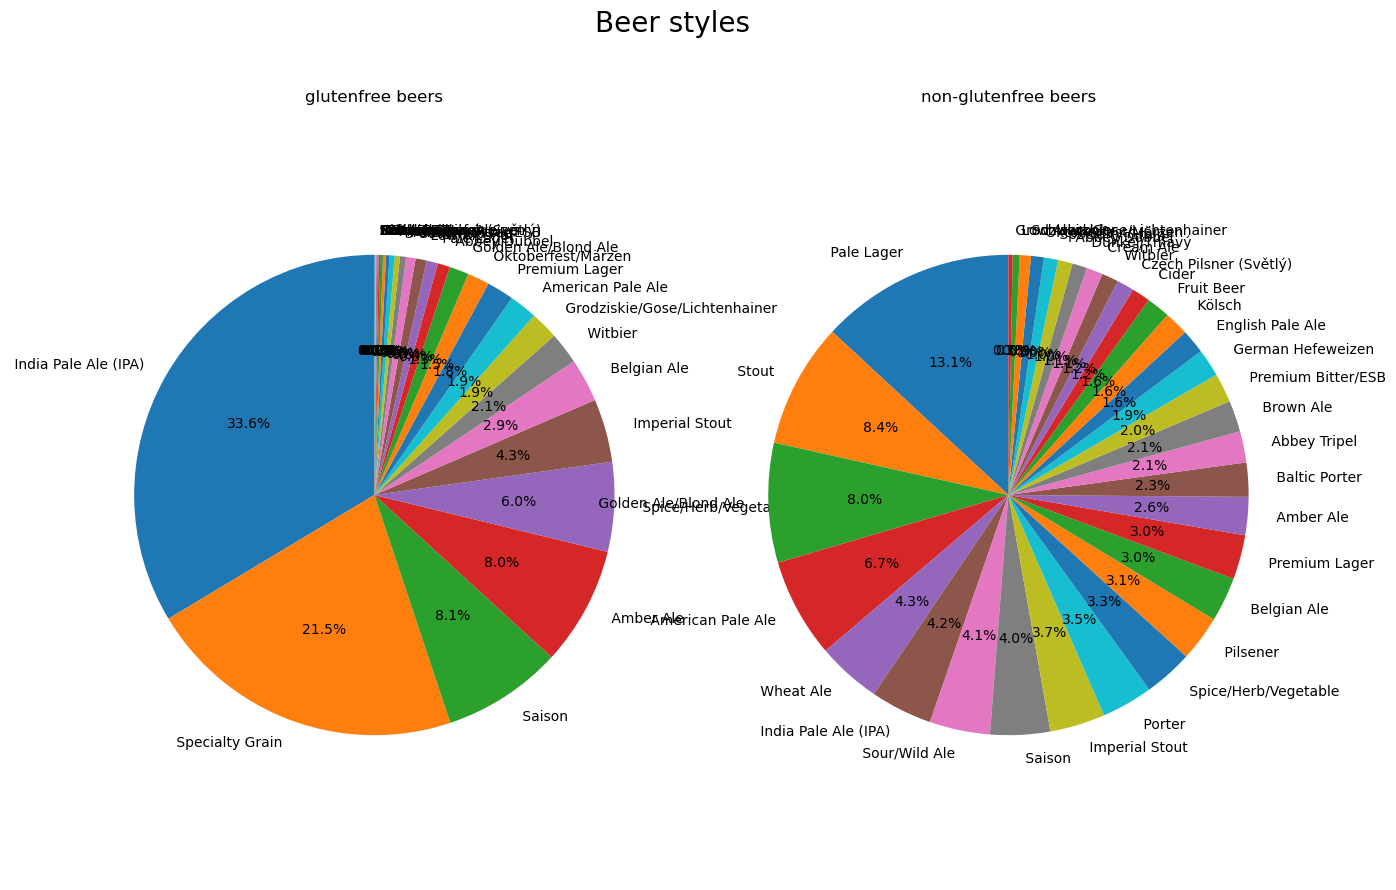

In [9]:
# show pie chart of beer styles
# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
fig.suptitle('Beer styles', fontsize=20)

# first subplot
ax1.set_title('glutenfree beers')
ax1.pie(reviews_en_fr[reviews_en_fr['glutenfree'] == True]['style'].value_counts(), labels=reviews_en_fr[reviews_en_fr['glutenfree'] == True]['style'].unique(), autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

# second subplot
ax2.set_title('non-glutenfree beers')
ax2.pie(reviews_en_fr[reviews_en_fr['glutenfree'] == False]['style'].value_counts(), labels=reviews_en_fr[reviews_en_fr['glutenfree'] == False]['style'].unique(), autopct='%1.1f%%', startangle=90)
ax2.axis('equal')

plt.show()

Unique gf beer styles: 31
Unique non-gf beer styles: 34


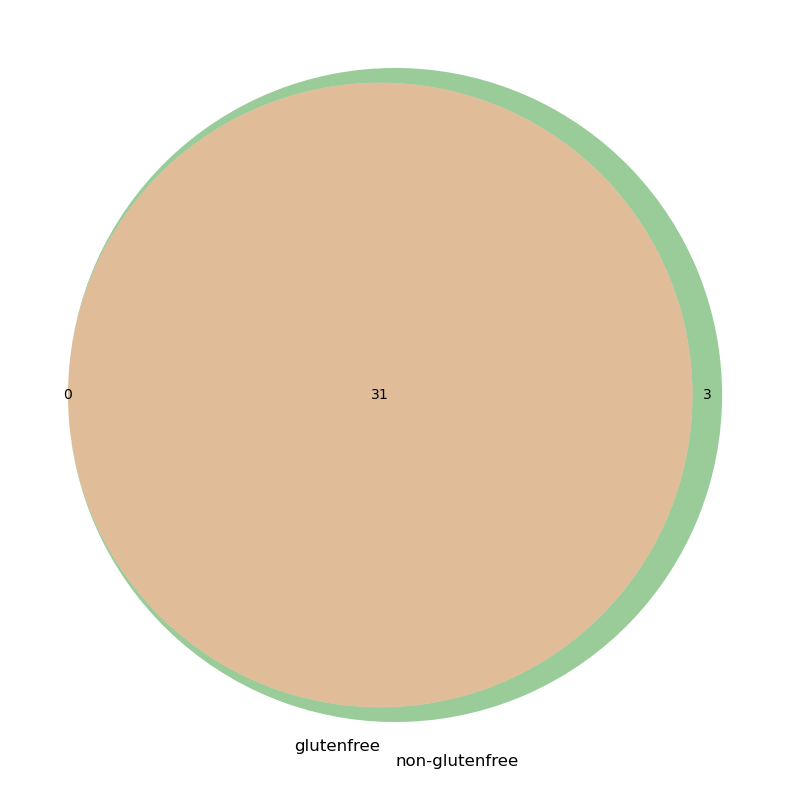

In [10]:
print("Unique gf beer styles:", reviews_en_fr[reviews_en_fr['glutenfree'] == True]['style'].nunique())
print("Unique non-gf beer styles:", reviews_en_fr[reviews_en_fr['glutenfree'] == False]['style'].nunique())

# show venn diagram of beer styles
fig, ax = plt.subplots(figsize=(10, 10))
venn2([set(reviews_en_fr[reviews_en_fr['glutenfree'] == True]['style'].unique()), set(reviews_en_fr[reviews_en_fr['glutenfree'] == False]['style'].unique())], set_labels=('glutenfree', 'non-glutenfree'))
plt.show()

## <span style="color: green;">PART 1. Spatiotemporal Analysis</span>

-> can fill with a lot of P2_AfterMilestone from the 'fix_nlp_and_text-formats' branch 

### Temporal analysis

## <span style="color: red;">We needed to study the temporal activity of the Bobos to see if they were plotting something shady.</span>
#### For that, our temporal analysis will be done in two steps.
<span style="color: red;">Step 1: Checking the number of reviews per year for gluten free beers globally.</span>
<span style="color: red;">Step 2: Checking the number of reviews per year for gluten free beers as a function of the location.</span>

We want to know if the temporal evolution of the reviews for glutenfree beers. Thus we plot the number of reviews per year for the glutenfree beers over time.

In [15]:
number_of_gf_reviews = Counter(reviews_en_fr[reviews_en_fr['glutenfree'] == True]['year'])
number_of_gf_reviews = sorted(number_of_gf_reviews.items(), key=lambda x: x[0])

Text(0.5, 1.0, 'Temporal analysis of glutenfree beers worldwide')

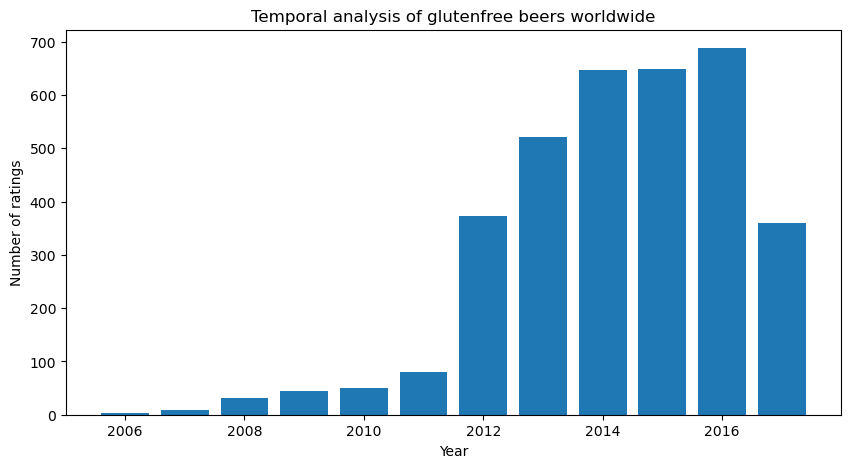

In [16]:
# make a list of ('year', 'number of ratings') tuples
plt.figure(figsize=(10,5))
plt.bar([x[0] for x in number_of_gf_reviews], [x[1] for x in number_of_gf_reviews])
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.title('Temporal analysis of glutenfree beers worldwide')

It showed that the ammount of reviews for gluten-free beers is increasing over time. Does it reflect the increasing popularity? Or it is simply because of the increase of total number of reviews in the dataset? To answer that, the temporal evolution of all reviews was computed and applied for normalization.

### <span style="color: green;">This plot clearly shows that the ammount of reviews for gluten-free beers is increasing.</span>
### <span style="color: blue;">However, seasoned detectives like us must always stay vigilant: is the reason for this increase because of the increase of the popularity of the site? Or is it because of the increase of total number of reviews in the dataset?</span>

In [17]:
# show unique values of the 'year' column
reviews_en_fr['year'].unique()

array([2016, 2013, 2014, 2015, 2017, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2004, 2005, 2003, 2002, 2001, 2000])

In [18]:
# count the number of reviews per year for all year, ignore nan
number_of_all_reviews = Counter(reviews_en_fr['year'])
number_of_all_reviews = sorted(number_of_all_reviews.items(), key=lambda x: x[0])

In [19]:
number_of_gf_reviews

[(2006, 3),
 (2007, 8),
 (2008, 32),
 (2009, 45),
 (2010, 50),
 (2011, 80),
 (2012, 373),
 (2013, 521),
 (2014, 646),
 (2015, 648),
 (2016, 688),
 (2017, 360)]

Text(0.5, 1.0, 'Temporal analysis of glutenfree beers proportion worldwide')

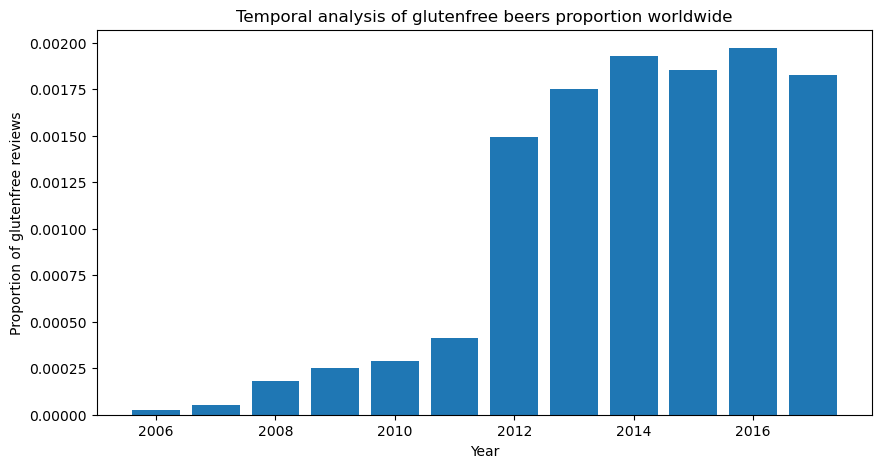

In [20]:
proportion_gf_reviews = []
for year, count in number_of_gf_reviews:
    # find the corresponding number of all reviews
    all_count = [x[1] for x in number_of_all_reviews if x[0] == year][0]
    proportion_gf_reviews.append((year, count / all_count))
    
# plot the proportion of glutenfree reviews over time
plt.figure(figsize=(10,5))
plt.bar([x[0] for x in proportion_gf_reviews], [x[1] for x in proportion_gf_reviews])
plt.xlabel('Year')
plt.ylabel('Proportion of glutenfree reviews')
plt.title('Temporal analysis of glutenfree beers proportion worldwide')

It shows that the increase of reviews for gluten-free beers is not due to the increase of total number of reviews. Thus, the increasing popularity of gluten-free beers is confirmed.

### <span style="color: green;">With that we are sure: the increase of gluten-free beers reviews is not due to the increase of the total number of reviews in the dataset. There can only be one explanation for that: the Bobos are clearly more and more present, globally.</span>

Next, the temporal evolution of numerical ratings is inspected.

In [21]:
def calculate_numerical_stats_by_year(df):
    '''
    df: filtered dataframe with numerical columns
    '''
    # Define the aggregation functions
    agg_funcs = {
        'rating': ['mean', 'std', 'sem'],
        'appearance': ['mean', 'std', 'sem'],
        'aroma': ['mean', 'std', 'sem'],
        'palate': ['mean', 'std', 'sem'],
        'taste': ['mean', 'std', 'sem'],
        'overall': ['mean', 'std', 'sem']
    }

    # Perform aggregation
    stats = df.groupby('year').agg(agg_funcs)

    # Rename the columns for clarity (optional)
    stats.columns = [f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col for col in stats.columns]

    # Reset index if needed
    stats.reset_index(inplace=True)

    return stats

In [22]:
gf_stats = calculate_numerical_stats_by_year(reviews_en_fr[reviews_en_fr['glutenfree'] == True])
ngf_stats = calculate_numerical_stats_by_year(reviews_en_fr[reviews_en_fr['glutenfree'] == False])

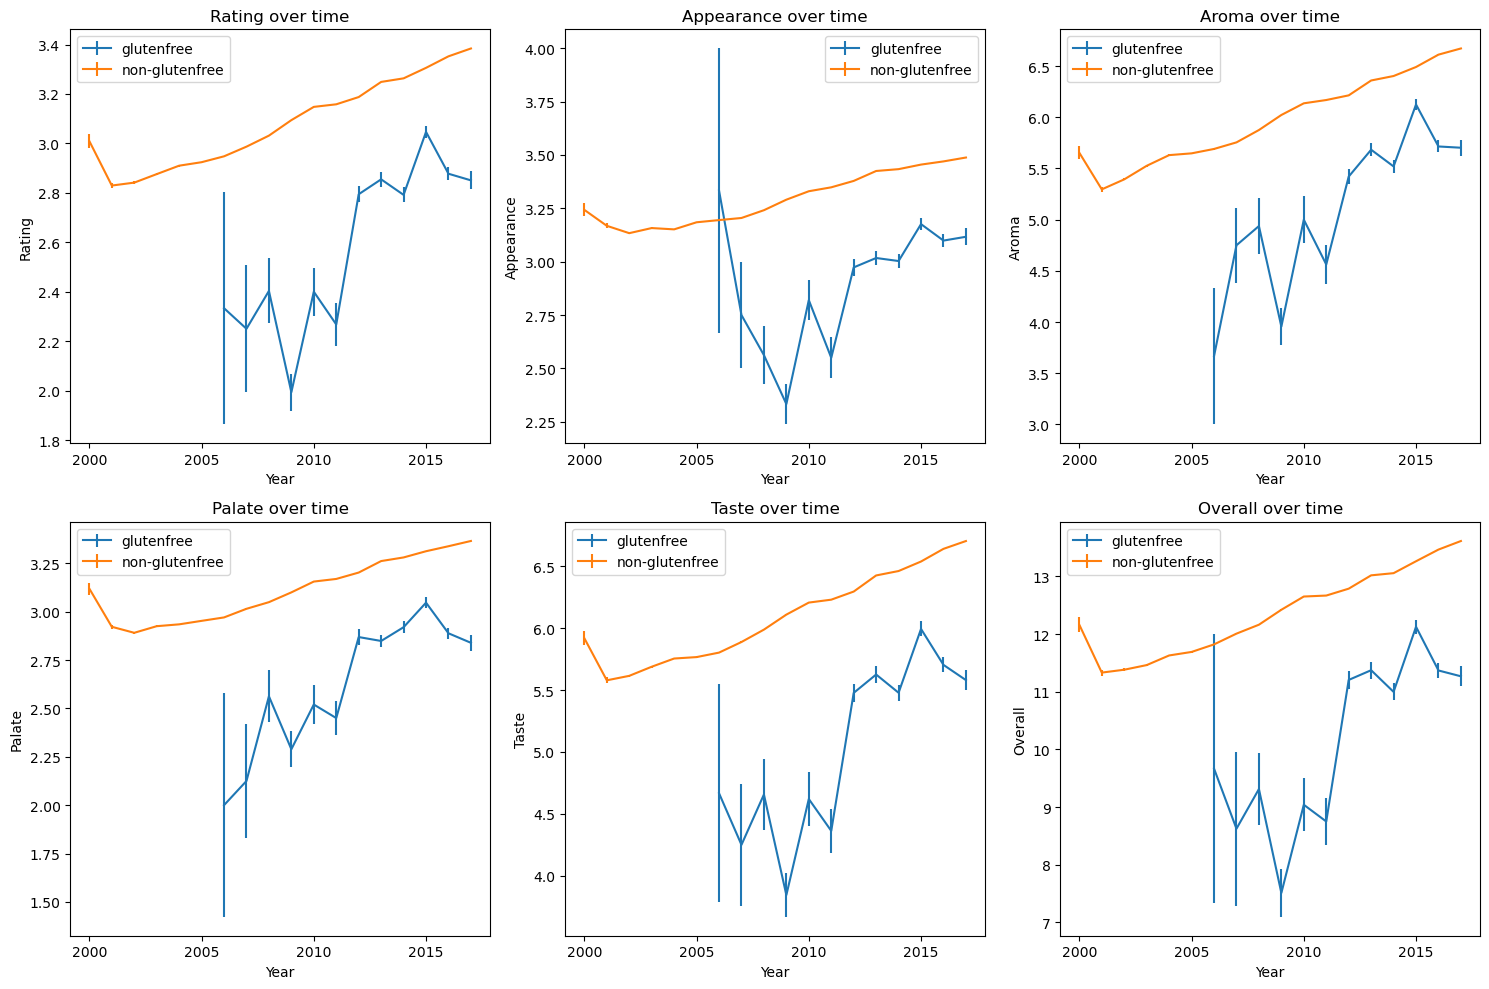

In [23]:
# plt the mean numerical stats over time for glutenfree and non-glutenfree beers
# plot rating, appearance, aroma, palate, taste, overall in 6 subplots
# plot the mean and the standard error of the mean (sem)

def plot_statistics(ax, x1, x2, y1, y2, yerr1, yerr2, label1, label2, xlabel, ylabel, title):
    ax.errorbar(x1, y1, yerr=yerr1, label=label1)
    ax.errorbar(x2, y2, yerr=yerr2, label=label2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

# Assuming gf_stats and ngf_stats are your DataFrames

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

statistics = ['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall']

for i, stat in enumerate(statistics, start=1):
    row = (i - 1) // 3
    col = (i - 1) % 3

    plot_statistics(
        axs[row, col],
        gf_stats['year'],
        ngf_stats['year'],
        gf_stats[f'{stat}_mean'],
        ngf_stats[f'{stat}_mean'],
        gf_stats[f'{stat}_sem'],
        ngf_stats[f'{stat}_sem'],
        'glutenfree',
        'non-glutenfree',
        'Year',
        stat.capitalize(),
        f'{stat.capitalize()} over time'
    )
    
    step = 5
    axs[row, col].set_xticks(ngf_stats['year'].astype(int).unique()[::step])

plt.tight_layout()
plt.show()

### Spatial analysis

Spatial analysis is performed to see how the glutenfree beers "users" and "reviews" are distributed over the world. Here the `geopandas` library is used to plot the data on a world map. `folium` library is used to overlay the data on an interactive map.

In [66]:
# Load the world map dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\asus\AppData\Local\Temp\ipykernel_8308\2098228512.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Glutenfree and non-glutenfree beer reviews are counted for each country.

In [94]:
# Count the number of reviews per country, ignore nan
number_of_gf_reviews_per_location = Counter(reviews_en_fr[reviews_en_fr['glutenfree'] == True]['location'])
number_of_ngf_reviews_per_location = Counter(reviews_en_fr[reviews_en_fr['glutenfree'] == False]['location'])

# ignore nan
number_of_gf_reviews_per_location.pop(np.nan)
number_of_ngf_reviews_per_location.pop(np.nan)

84285

Temporal evolution of the number of reviews for glutenfree beers is also counted in the same manner.

In [95]:
# Count unique users per country, ignore nan
# count location: number of unique users
number_of_gf_users_per_location = reviews_en_fr[reviews_en_fr['glutenfree'] == True].groupby('location')['user_id'].nunique()

In [147]:
# Group by location and see the number of gf comment over year
number_of_gf_reviews_per_location_year = reviews_en_fr[reviews_en_fr['glutenfree'] == True].groupby(['location', 'year']).size()
# name the column
number_of_gf_reviews_per_location_year = number_of_gf_reviews_per_location_year.reset_index(name='count')

In [148]:
number_of_gf_reviews_per_location_year = number_of_gf_reviews_per_location_year.pivot(index='location', columns='year', values='count').fillna(0)

In [149]:
number_of_gf_reviews_per_location_year

year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,0.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,5.0,5.0,7.0,12.0
Austria,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0
Belarus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0
Belgium,0.0,0.0,3.0,0.0,0.0,2.0,3.0,17.0,13.0,25.0,24.0,13.0
Cambodia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, West Virginia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
"United States, Wisconsin",0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,4.0,3.0,0.0,1.0
"United States, Wyoming",0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [173]:
# show available countries in world dataset
world_list = world['name'].unique()
world_list

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

As seen from the above dataframe and world_list, there is a discrepancy between the location names in the beer dataset and the country names in the world dataset. Thus it is necessary to map the location names to the country names. Such a many-to-one mapping is performed through the following steps.

Define the mapping dictionary

In [174]:
# establish mapping relationship between country names in the world map dataset and the review dataset
# Key: country name in the review dataset
# Value: country name in the world map dataset
country_mapping_many_to_one = {
    "United States": "United States of America",
    "Hong Kong": "China",
    "Macau": "China",
    "Scotland": "United Kingdom",
    "Wales": "United Kingdom",
    "England": "United Kingdom",
    "Faroe Islands": "Denmark",
    "Slovak Republic": "Slovakia",
    "Hawaii": "United States of America",
    "Fiji Islands": "Fiji",
    "American Samoa": "United States of America",
    "Dem Rep of Congo": "Dem. Rep. Congo",
    "Isle of Man": "United Kingdom",
    "Guam": "United States of America",
    "Macedonia": "North Macedonia",
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "Bermuda": "United Kingdom",
    "Czech Republic": "Czechia",
    "French Guiana": "France",
    "Jersey": "United Kingdom",
}

In [175]:
# Key: country name in the world map dataset
# Value: country name in the review dataset
country_mapping_one_to_many = {
    "United States of America": ["United States", "Hawaii", "American Samoa", "Guam", "United States of America"],
    "China": ["Hong Kong", "Macau", "China"],
    "United Kingdom": ["Scotland", "Wales", "England", "Isle of Man", "Jersey", "Bermuda", "United Kingdom"],
    "Denmark": ["Faroe Islands"],
    "Slovakia": ["Slovak Republic"],
    "Fiji": ["Fiji Islands"],
    "Dem. Rep. Congo": ["Dem Rep of Congo"],
    "North Macedonia": ["Macedonia"],
    "Bosnia and Herz.": ["Bosnia and Herzegovina"],
    "Czechia": ["Czech Republic"],
    "France": ["French Guiana", "France"],
}

Define the mapping function. When merging multiple rows of the same country, the values are summed up.

In [156]:
def correct_country_name(dict, country_mapping_one_to_many):
    correct_dict = dict.copy()
    for key, value in dict.items():
        for country in country_mapping_one_to_many.keys():
            if key.split(",")[0] in country_mapping_one_to_many[country]:
                if correct_dict.get(country) is None:
                    correct_dict[country] = correct_dict[key]
                else:
                    correct_dict[country] += correct_dict[key]
                # delete the old key-value pair
                if key != country:
                    del correct_dict[key]
    return correct_dict

def correct_country_name_evolution(dataframe, country_mapping_one_to_many):
    correct_dict = dataframe.copy()
    for key in dataframe.index:
        for country in country_mapping_one_to_many.keys():
            if key.split(",")[0] in country_mapping_one_to_many[country]:
                if country not in correct_dict.index:
                    # create a new data row
                    correct_dict.loc[country] = correct_dict.loc[key]
                else:
                    # sum up the values of the two rows (sum up the number of reviews in each year)
                    correct_dict.loc[country] += correct_dict.loc[key]
                # delete the old key-value pair
                if key != country:
                    correct_dict.drop(key, inplace=True)
    return correct_dict
    

In [157]:
# correct the country name
number_of_gf_users_per_location = correct_country_name(number_of_gf_users_per_location, country_mapping_one_to_many)
number_of_gf_reviews_per_location = correct_country_name(number_of_gf_reviews_per_location, country_mapping_one_to_many)
number_of_ngf_reviews_per_location = correct_country_name(number_of_ngf_reviews_per_location, country_mapping_one_to_many)

In [158]:
# correct the country name evolution
number_of_gf_reviews_per_location_year = correct_country_name_evolution(number_of_gf_reviews_per_location_year, country_mapping_one_to_many)

In [160]:
number_of_gf_reviews_per_location_year.head()

year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,0.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,5.0,5.0,7.0,12.0
Austria,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0
Belarus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0
Belgium,0.0,0.0,3.0,0.0,0.0,2.0,3.0,17.0,13.0,25.0,24.0,13.0
Cambodia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


With the matched country names, the spatial analysis is continued.

Here we define `ratio` as the ratio of the number of reviews for glutenfree beers to the non-glutenfree beers. For each country, the ratio is a representative of the "enrichment of glutenfree beer reviews", reflecting the popularity of glutenfree beers in that country.

We then color the countries according to the ratio, and visualize the absolute number of users and reviews for glutenfree beers at the same time. This step was done using an interactive map.

In [102]:
ratio_by_location = pd.DataFrame(columns=['country', 'gf_count', 'ngf_count', 'ratio', 'gf_users'])

# Plot using a diverging color scheme
for country in world_list:
    if country in number_of_gf_reviews_per_location and country in number_of_ngf_reviews_per_location:
        gf_count = number_of_gf_reviews_per_location[country]
        ngf_count = number_of_ngf_reviews_per_location[country]
        ratio = gf_count / ngf_count if ngf_count != 0 else 0  # Avoid division by zero
        gf_users = number_of_gf_users_per_location[country]
        # add new row to the dataframe
        ratio_by_location.loc[len(ratio_by_location)] = [country, gf_count, ngf_count, ratio, gf_users]


Static map (can be skipped)

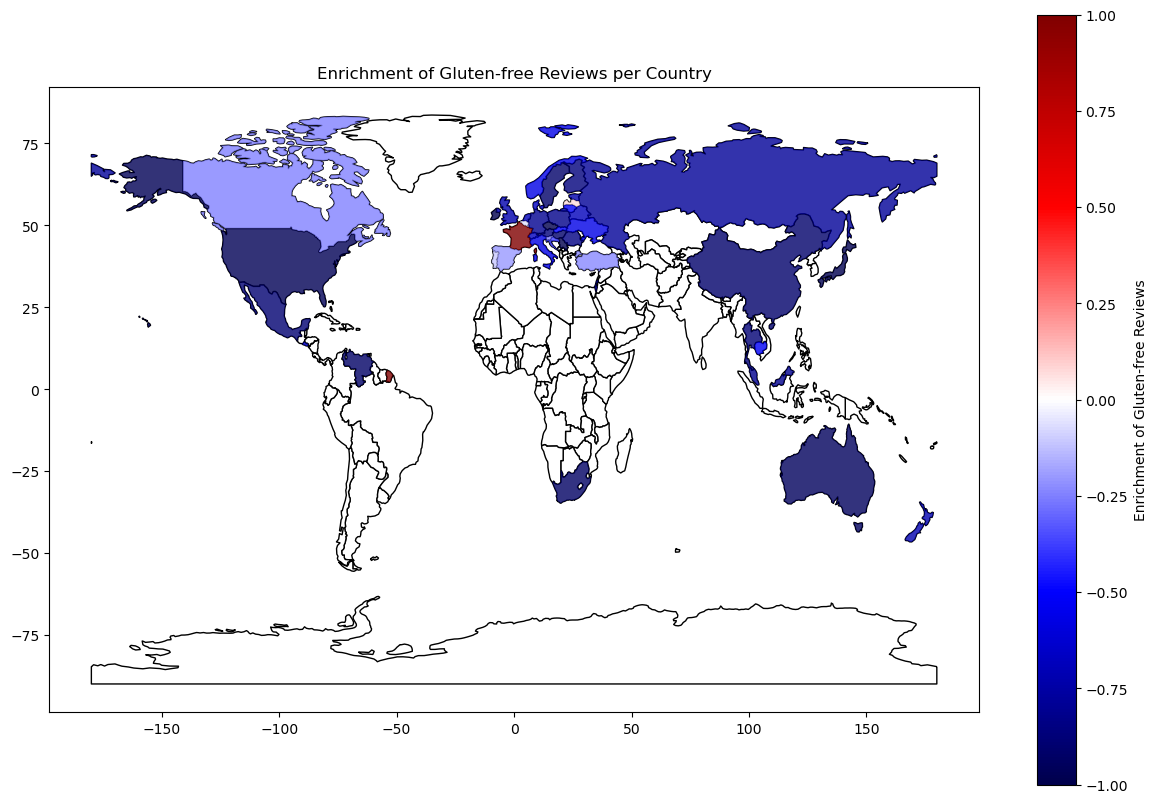

In [103]:
# Plot onto the world map
fig, ax = plt.subplots(figsize=(15, 10))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')

for country in ratio_by_location['country']:
    # define diverging color scheme using normalized ratio which ranges from -1 to 1
    color = plt.cm.seismic((ratio_by_location[ratio_by_location['country'] == country]['ratio'].values[0] - ratio_by_location['ratio'].min()) / (ratio_by_location['ratio'].max() - ratio_by_location['ratio'].min()))
    world[world['name'] == country].plot(ax=ax, color=color, alpha=0.8)

plt.title('Enrichment of Gluten-free Reviews per Country')

# Create a ScalarMappable for the color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.seismic, norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])  # Set an empty array to avoid errors

# Add color bar to the figure using the specified Axes (ax)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Enrichment of Gluten-free Reviews')

plt.show()

Interactive map. The size of the human icon represents the number of users, but the size-scaling follows a cubic root function to avoid the dominance of large countries (I decided arbitrarily).

In [119]:
# create the same plot but with folium interactive map for the ratio of glutenfree reviews per country
m = folium.Map(location=[0, 0], zoom_start=2)

    
# Create a choropleth layer with Folium
choropleth_layer = folium.Choropleth(
    geo_data=world,
    name='choropleth',
    data=ratio_by_location,
    columns=['country', 'ratio'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Enrichment of Gluten-free Reviews',
    nan_fill_color='white',  # Color for countries without data
    nan_fill_opacity=1.0     # Opacity for countries without data
).add_to(m)

# Ensure choropleth_layer is added before CircleMarker
choropleth_layer.add_to(m)

# compute max gf_users
max_gf_users = ratio_by_location['gf_users'].max()

# Add circle markers to the map to indicate the number of gf_users per country
for country in ratio_by_location['country']:
    if country in world_list:
        gf_users = ratio_by_location[ratio_by_location['country'] == country]['gf_users'].values[0]
        
        # Calculate icon size based on the proportion of GF users to the maximum
        icon_size = (2 + 36 * np.cbrt(gf_users / max_gf_users), (2 + 36 * np.cbrt(gf_users / max_gf_users))*1.6)

        # Define a FontAwesome human icon (replace 'path/to/human-icon.png' with the actual path)
        human_icon = folium.CustomIcon(
            icon_image=os.path.join(CODE_DIR, 'icon', 'person-solid_rb.png'),
            icon_size=icon_size,
            icon_anchor=(icon_size[0] // 2, icon_size[1]),
            popup_anchor=(0, -icon_size[1])
        )
        
        if country == 'France':
            location = [46.2276, 2.2137]
        else:
            # print location of France
            location = [world[world['name'] == country]['geometry'].values[0].centroid.y, world[world['name'] == country]['geometry'].values[0].centroid.x]
        folium.Marker(
            location=location,
            radius=gf_users / 10,
            popup=f"{country}: {gf_users} GF users, {ratio_by_location[ratio_by_location['country'] == country]['gf_count'].values[0]:d} reviews",
            icon = human_icon
        ).add_to(m)

# save the map as html
# the saved map should be able to be putted onto the webpage and be interactive
m.save(os.path.join(DATA_DIR, "gf_reviews_map.html"))


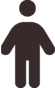
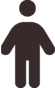
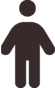
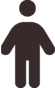
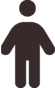
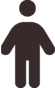
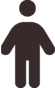
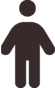
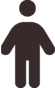
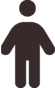
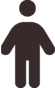
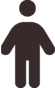
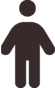
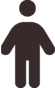
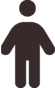
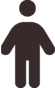
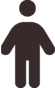
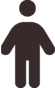
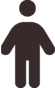
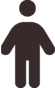
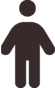
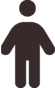
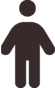
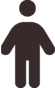
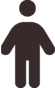
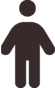
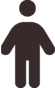
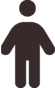
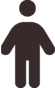
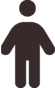
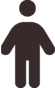
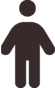
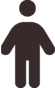
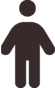
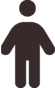
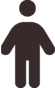
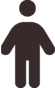
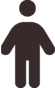
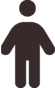
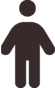
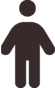
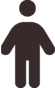
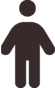
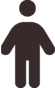
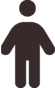

In [120]:
m

In [161]:
# sort by ratio
ratio_by_location.sort_values(by=['ratio'], ascending=False, inplace=True)
ratio_by_location

,country,gf_count,ngf_count,ratio,gf_users
8,France,116,17548,0.006610,42
20,Latvia,10,2662,0.003757,5
27,Belgium,100,29545,0.003385,29
29,Portugal,12,3708,0.003236,4
30,Spain,41,13820,0.002967,15
26,Luxembourg,3,1025,0.002927,2
23,Turkey,6,2103,0.002853,4
39,Slovenia,14,4941,0.002833,4
0,Canada,799,282770,0.002826,161
24,Croatia,41,16880,0.002429,14


Last but not least for this part, it would be interesting to see the temporal evolution of gf reviews in specific countries. Here France, Belgium, Canada and United States of America are selected.

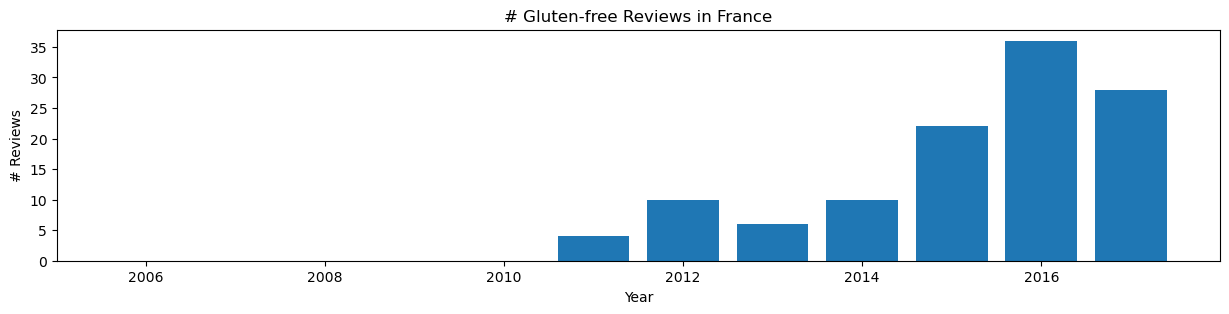

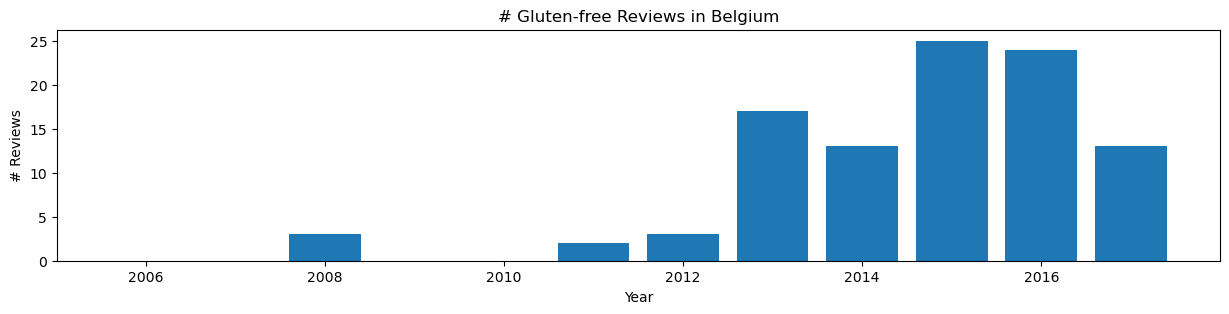

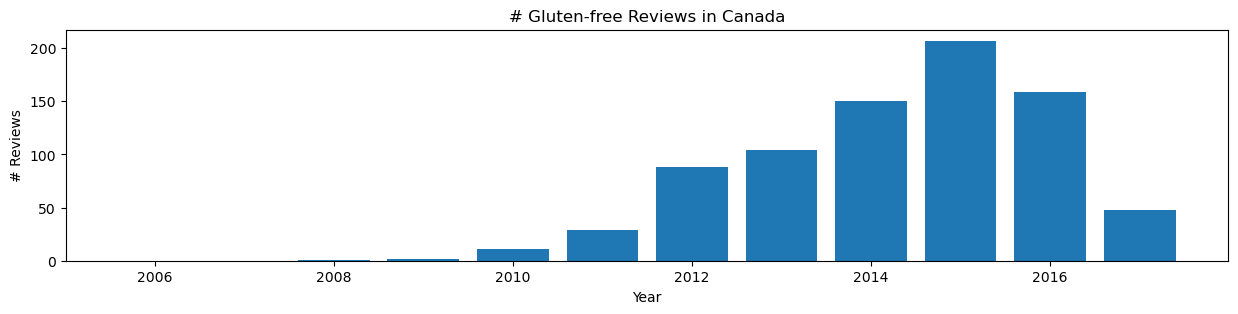

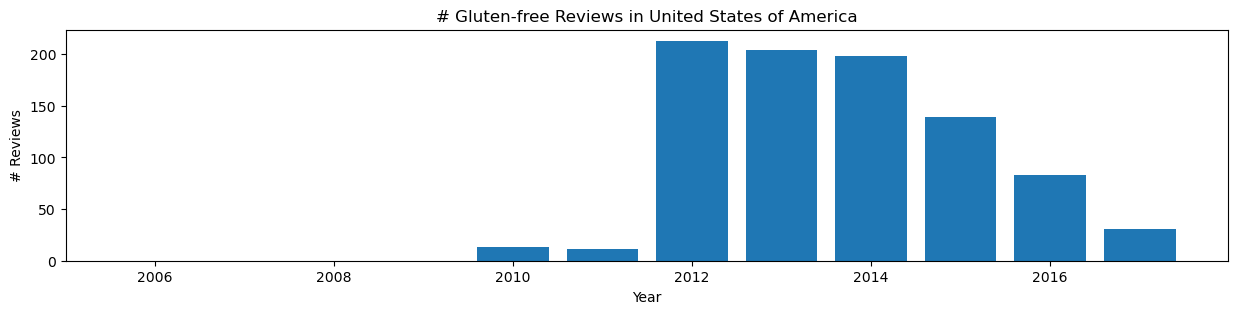

In [171]:
# plot barplot of the frequency of glutenfree reviews per country
def plot_gf_freq_by_country(df, country):
    plt.figure(figsize=(15, 3))
    plt.bar(df.columns, df.loc[country])
    plt.xlabel('Year')
    plt.ylabel('# Reviews')
    plt.title(f'# Gluten-free Reviews in {country}')
    plt.show()
    
plot_gf_freq_by_country(number_of_gf_reviews_per_location_year, 'France')
plot_gf_freq_by_country(number_of_gf_reviews_per_location_year, 'Belgium')
plot_gf_freq_by_country(number_of_gf_reviews_per_location_year, 'Canada')
plot_gf_freq_by_country(number_of_gf_reviews_per_location_year, 'United States of America')

## <span style="color: lightgreen;">correlation of the reviews with the ratings</span> TBD


In [3]:
import pickle
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


In [ ]:
import nltk
import ssl

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

from nltk.corpus import wordnet
# Download the OMW data
nltk.download('omw-1.4')
# Download WordNet
nltk.download('wordnet')

In [2]:
with open("reviews_en_fr.pkl", 'rb') as f:
    en_fr= pickle.load(f)
en_fr

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,text,location,year,review,lang,glutenfree
0,Kowloon Bay Gluten Free IPA,436710,Kowloon Bay Brewery,25260,India Pale Ale (IPA),6.6,2016-07-26 10:00:00,CacheManyHose,282160,3,...,2,6,14,3.2,Drank at Home: Eat To Live cafe. Floral hop n...,Hong Kong,2016.0,True,en,True
1,Glutenberg 1er Anniversaire,182791,Glutenberg Brewing Company,13241,Specialty Grain,7.5,2013-07-14 10:00:00,BiereLuc,131174,3,...,3,8,16,3.7,Bière cuivrée. Nez houblon-caramel. En bouche...,Canada,2013.0,True,fr,True
2,Glutenberg 8,162109,Glutenberg Brewing Company,13241,Specialty Grain,5.0,2014-10-04 10:00:00,BiereLuc,131174,3,...,2,7,15,3.4,"En fouillant dans mes carnets, je suis retomb...",Canada,2014.0,True,fr,True
3,Glutenberg Belge de Saison 2013,204934,Glutenberg Brewing Company,13241,Saison,7.0,2013-02-21 11:00:00,BiereLuc,131174,3,...,3,8,18,4.0,"(Version 2013, recette différente) - Belle co...",Canada,2013.0,True,fr,True
4,Glutenberg Belge de Saison 2014,253815,Glutenberg Brewing Company,13241,Saison,7.0,2014-04-22 10:00:00,BiereLuc,131174,3,...,3,7,15,3.4,"Bière couleur paille, limpide et mousseuse. L...",Canada,2014.0,True,fr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255670,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-12 11:00:00,czar,104498,3,...,3,7,14,3.5,"bottle shared by tom10101, thanks bro. pours ...",NaN,NaN,True,en,False
3255671,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-11 11:00:00,DCLawyer,221043,4,...,4,6,16,3.7,Bottle->tulip. Very cloudy orange with frothy...,NaN,NaN,True,en,False
3255672,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-08 11:00:00,jtclockwork,104199,4,...,3,7,14,3.5,Bottle. Pours amber peach with white head. No...,NaN,NaN,True,en,False
3255673,Maine Beer 2013,236777,Maine Beer Company,10659,American Pale Ale,5.5,2013-12-03 11:00:00,RamyG4,79534,5,...,4,8,14,4.0,Bottle. Mostly opaque golden beer with a medi...,NaN,NaN,True,en,False


In [5]:
language_models = {
    'en': spacy.load('en_core_web_sm'),
    'fr': spacy.load('fr_core_news_sm')
}

In [6]:
reduce=en_fr[['user_id','glutenfree', 'text','lang']]

## French analysis

In [7]:
french=reduce[reduce['lang']=='fr']

In [8]:
#We group by user and we count how many glutenfree beers, each user have rated
French=french.groupby('user_id').sum()
French.drop(columns=['lang'], inplace=True)

In [9]:
French

,glutenfree,text
user_id,,
181,0,"golden colour, not much hopped, quite flat am..."
195,0,La 8 de Belghe Brasse est une bière d’abbaye ...
440,0,"Has a very unique flavor, it’s not a good one..."
765,0,C’est de la merde Américaine.It is American s...
1880,0,on tap at 04berlinerbierfest. decent pils. pa...
...,...,...
474595,0,Belle robe ambrée un peu sombre. Une amertume...
479165,0,Rousse de type anglaise sans amertume un peu ...
481491,0,Wow!! Une excellente bière de grande qualité....


In [10]:
#Glutenfree users are defined as beer consumer that have rated one or more than one glutenfree beer
French['GF_user']=French['glutenfree'].apply(lambda x: x>=1)
French.drop(columns=['glutenfree'], inplace=True)
French

,text,GF_user
user_id,,
181,"golden colour, not much hopped, quite flat am...",False
195,La 8 de Belghe Brasse est une bière d’abbaye ...,False
440,"Has a very unique flavor, it’s not a good one...",False
765,C’est de la merde Américaine.It is American s...,False
1880,on tap at 04berlinerbierfest. decent pils. pa...,False
...,...,...
474595,Belle robe ambrée un peu sombre. Une amertume...,False
479165,Rousse de type anglaise sans amertume un peu ...,False
481491,Wow!! Une excellente bière de grande qualité....,False


In [11]:
French['GF_user'].sum()# only 78 glutenfree beers consumers

78

### Text Processing

In [12]:
EXCLUDE_CHARS = set(punctuation).union(set('’'))

In [13]:
#clean the text: remove punctuation
def clean_line(line):
    for char in EXCLUDE_CHARS:
        line = line.replace(char, ' ')
    return line.lower()
French["text"] = French["text"].apply(clean_line)
French["text"]

user_id
181        golden colour  not much hopped  quite flat am...
195        la 8 de belghe brasse est une bière d abbaye ...
440        has a very unique flavor  it s not a good one...
765        c est de la merde américaine it is american s...
1880       on tap at 04berlinerbierfest  decent pils  pa...
                                ...                        
474595     belle robe ambrée un peu sombre  une amertume...
479165     rousse de type anglaise sans amertume un peu ...
481491     wow   une excellente bière de grande qualité ...
481968     bière raifraichissante  bonne blanche d été a...
485613     de belles notes boisées  une peu de noix  il ...
Name: text, Length: 824, dtype: object

In [58]:
#Create a bag of word
vectorizer = CountVectorizer()

#create bag of words features
X = vectorizer.fit_transform(French['text'].values)

print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])
print(X)

Number of samples: 824
Number of features: 45391
  (0, 23075)	1
  (0, 14182)	2
  (0, 30863)	1
  (0, 30017)	1
  (0, 24401)	1
  (0, 35305)	1
  (0, 21518)	1
  (0, 7867)	1
  (0, 31525)	1
  (0, 8827)	1
  (0, 42739)	1
  (0, 39527)	1
  (1, 14182)	1
  (1, 26810)	1
  (1, 16371)	2
  (1, 10354)	1
  (1, 11414)	1
  (1, 20147)	1
  (1, 42655)	2
  (1, 10690)	1
  (1, 6398)	1
  (1, 42532)	1
  (1, 19591)	1
  (1, 19187)	1
  (1, 15445)	1
  :	:
  (822, 43220)	2
  (822, 9593)	1
  (822, 22177)	1
  (822, 39384)	1
  (822, 21810)	2
  (822, 22002)	1
  (822, 42025)	1
  (822, 35748)	2
  (822, 11829)	2
  (822, 25989)	2
  (822, 35513)	1
  (823, 16371)	3
  (823, 42655)	1
  (823, 20215)	1
  (823, 42628)	1
  (823, 32956)	1
  (823, 30775)	1
  (823, 30879)	1
  (823, 7945)	1
  (823, 24782)	1
  (823, 11564)	1
  (823, 12444)	1
  (823, 28458)	1
  (823, 10373)	1
  (823, 10973)	1


In [120]:
#In this cell, we will filter the feature words, to keep only adjectives and adverbs, and meaningful words
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Function to check if a word has synsets in WordNet
def has_synsets(word, lang='eng'):
    synsets = wordnet.synsets(word, lang=lang)
    return len(synsets) > 0

# Function to filter the features names that are not adjectives or adverbs
def filter_features_by_pos(features, pos_tags):
    doc = nlp(' '.join(features))
    return [token.text.lower() for token in doc if token.pos_ in pos_tags ]

# Filter feature names to include only adjectives and adverbs
adjectives_and_adverbs = filter_features_by_pos(feature_names, {"ADJ", "ADV"})

#Filter again to remove word that have no definition into the french dictionnary:
filtered_features = [word for word in adjectives_and_adverbs if has_synsets(word, lang='fra')]

# Create a mask to filter the columns in the sparse matrix
feature_mask = [i for i, feature in enumerate(feature_names) if feature in filtered_features]
filtered_matrix = X[:, feature_mask]


In [121]:
#Now we have 'only' 814 features, great cleaning!
print('Number of samples:',filtered_matrix.toarray().shape[0])
print('Number of features:',filtered_matrix.toarray().shape[1])
print(filtered_matrix)

Number of samples: 824
Number of features: 814
  (1, 470)	1
  (1, 563)	1
  (1, 745)	1
  (2, 783)	2
  (3, 470)	1
  (4, 563)	2
  (4, 82)	1
  (5, 777)	1
  (5, 602)	1
  (6, 470)	4
  (6, 586)	1
  (6, 448)	1
  (8, 563)	1
  (8, 745)	1
  (8, 255)	1
  (9, 783)	1
  (11, 470)	1
  (11, 777)	2
  (11, 484)	1
  (12, 602)	1
  (13, 470)	1
  (14, 761)	1
  (16, 470)	7
  (16, 777)	3
  (16, 544)	1
  :	:
  (815, 777)	1
  (815, 546)	1
  (815, 179)	1
  (815, 498)	2
  (815, 291)	1
  (815, 421)	1
  (816, 470)	1
  (816, 777)	2
  (816, 712)	1
  (817, 470)	1
  (818, 470)	3
  (818, 777)	1
  (818, 565)	1
  (818, 22)	1
  (818, 640)	1
  (818, 199)	1
  (818, 124)	1
  (818, 385)	1
  (819, 470)	1
  (819, 777)	1
  (821, 777)	3
  (821, 482)	1
  (822, 470)	2
  (822, 315)	1
  (823, 498)	1


### Logistic classifier for identifying gluten-free consumers based on their vocabulary usage

In [128]:
#In this cell, we perform a slight rescaling of the data.
#This adjustment is made to address the presence of numerous zero values and occasional instances of high counts.
#This could alleviate the issue of the optimizer not converging for classifier algorithms.

# Create a MaxAbsScaler instance
scaler = MaxAbsScaler()

# Scale the sparse features
X_scaled = scaler.fit_transform(filtered_matrix)

In [130]:
#Let's do a crossvalidate to find the best regularization parameter
accs = []

#the grid of regularization parameter 
grid = [0.01,0.1,1,10,100,1000,10000]

for c in grid:
    
    #initialize the classifier
    clf = LogisticRegression(random_state=1, solver='liblinear',C = c)
    
    #crossvalidate
    scores = cross_val_score(clf, X_scaled,French['GF_user'].values, cv=10)
    accs.append(np.mean(scores))

Text(0, 0.5, 'Crossvalidation accuracy')

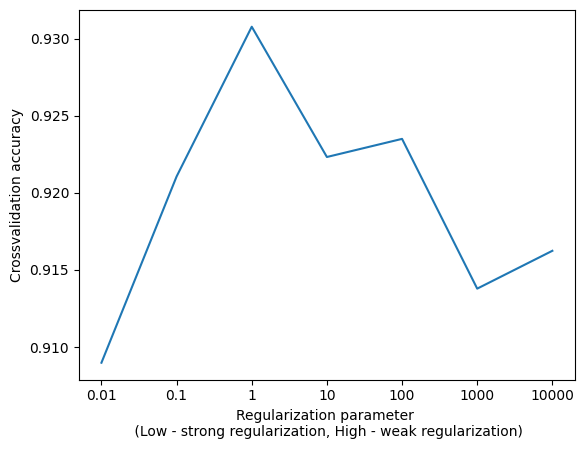

In [131]:
#The best regularization parameter seems to be close to one
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')

In [132]:
#split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, French['GF_user'], test_size=0.2, random_state=42)
logit = LogisticRegression(random_state=0, solver='lbfgs', C=1).fit(X_train, Y_train)

#predict on the test set
print('Accuracy:',logit.score(X_test,Y_test))

Accuracy: 0.9393939393939394


In [200]:
#Explore the word features that most effectively predict gluten-free consumers
coefs=logit.coef_[0]
top = np.argpartition(coefs, -100)[-100:]
print(np.array(filtered_features)[top])

['demande' 'endroit' 'automatiquement' 'sobrement' 'effrayant' 'fier'
 'marier' 'automnal' 'déposant' 'quartier' 'chantilly' 'salive' 'chlore'
 'excès' 'piquant' 'froid' 'ouverture' 'total' 'intense' 'blondasse'
 'rapidement' 'imperceptible' 'inquiet' 'banal' 'hipster' 'méfier' 'métal'
 'direct' 'indétectable' 'honorable' 'indescriptible' 'diable' 'mûr'
 'nordique' 'la' 'principal' 'abrupt' 'classique' 'remarquablement'
 'nougat' 'supportable' 'standard' 'négliger' 'potable' 'cormier' 'dureté'
 'collabo' 'terrible' 'mythique' 'microbrasserie' 'spécifier' 'décevant'
 'déconcertant' 'marque' 'transparent' 'sort' 'sommelier' 'déroutant'
 'bénéficier' 'positivement' 'triple' 'désagréable' 'bourru' 'très'
 'manque' 'exact' 'excellent' 'exceptionnel' 'extravagant' 'sanguinaire'
 'patiemment' 'farine' 'baisse' 'pêcheur' 'fiable' 'oranger' 'invisible'
 'sacrement' 'flic' 'fluide' 'quasi' 'appartement' 'front' 'frédéric'
 'récidive' 'pale' 'genial' 'rural' 'insipide' 'volant' 'palpable'
 'agglu

### Can a simple classifier utilizing words exclusive to gluten-free consumers can have higher accuracy?

In [136]:
#Convert the bag of word to a dataframe for user-friendly interpretation
bag_word=pd.DataFrame(columns=filtered_features,data=filtered_matrix.toarray())

In [151]:
bag_word['GF_user']=[int(data) for data in French['GF_user'].values]
bag_word

,am,abbatial,abominable,abondant,aboutissement,abricotier,abrupt,absent,acceptable,acceptablement,...,vulnérable,végétal,vérifier,véritable,weizenbier,whisky,winslow,worth,âme,GF_user
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
X_train, X_test = train_test_split(bag_word, test_size=0.2, random_state=36373)

In [158]:
#Compare the absolute frequency of each word's usage between gluten-free and non-gluten-free consumers for each feature word.
train=X_train.groupby('GF_user').sum()
train

,am,abbatial,abominable,abondant,aboutissement,abricotier,abrupt,absent,acceptable,acceptablement,...,volubile,vulnérable,végétal,vérifier,véritable,weizenbier,whisky,winslow,worth,âme
GF_user,,,,,,,,,,,,,,,,,,,,,
0,0,0,10,0,0,3,45,20,0,17,...,0,0,42,1,16,2,37,0,6,3
1,0,1,32,1,1,0,74,98,5,123,...,7,2,204,8,107,0,167,2,2,22


In [173]:
#Reverse the dataframe and ename columns
GF_words = train.T
GF_words.columns=['NGF','GF']
GF_words

,NGF,GF
am,0,0
abbatial,0,1
abominable,10,32
abondant,0,1
aboutissement,0,1
...,...,...
weizenbier,2,0
whisky,37,167
winslow,0,2
worth,6,2


In [175]:
#Look at words only used by glutenfree consumer
gf=GF_words[GF_words['NGF']==0][['GF']]
gf

,GF
am,0
abbatial,1
abondant,1
aboutissement,1
acceptable,5
...,...
voilier,1
volant,1
volubile,7
vulnérable,2


In [179]:
gf.sort_values( by='GF',ascending=False, inplace=True)
Gf=gf[gf['GF']>10]
Gf

,GF
confortable,66
allongement,47
botanique,32
châtaigne,32
irréprochable,30
principal,25
attribuable,21
remous,20
adieu,19
fier,18


In [184]:
Gf.index

Index(['confortable', 'allongement', 'botanique', 'châtaigne', 'irréprochable',
       'principal', 'attribuable', 'remous', 'adieu', 'fier', 'déluge',
       'indétectable', 'intelligent', 'slovaque', 'incontrôlable',
       'confortablement', 'front', 'coude', 'strictement', 'affreusement',
       'agréable', 'redoutable', 'fiable', 'admirable', 'central',
       'dernièrement'],
      dtype='object')

In [196]:
subset=X_test[Gf.index]
#define our 'simple classifier', as follow: 
#if any word from the previously defined list is present in the text, the individual is classified as a gluten-free consumer 
    return row.sum()>0
classification=subset.apply(simple_classifier, axis=1)

In [197]:
classification

440    False
795    False
560    False
688    False
775    False
       ...  
771    False
760    False
435    False
323    False
632    False
Length: 165, dtype: bool

In [198]:
X_test['GF_user']

440    0
795    0
560    0
688    0
775    0
      ..
771    1
760    0
435    0
323    0
632    0
Name: GF_user, Length: 165, dtype: int64

In [199]:
print("Accuracy: ", (classification == X_test['GF_user']).sum() / len(classification))

Accuracy:  0.9393939393939394


The accuracy is identical with a simpler classifier!

## Identify clusters

/Users/mathieu/Projets/2023-2024/2023/ADA/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


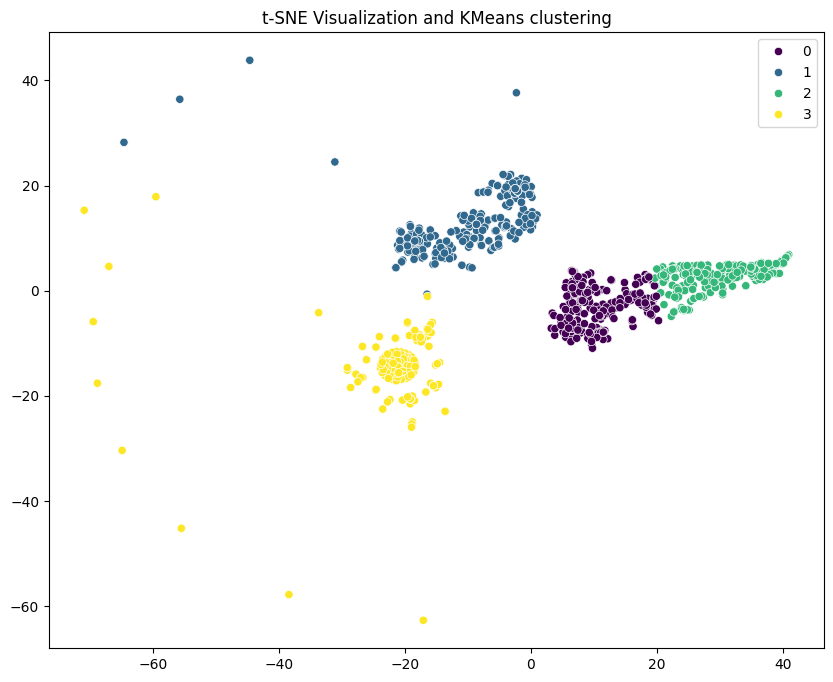

In [232]:
# Apply t-SNE to the previous bag of words representation for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(bag_word.drop(columns=['GF_user']))

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

# Add the cluster information to the DataFrame
bag_word['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette='viridis')
plt.title('t-SNE Visualization and KMeans clustering')
plt.show()


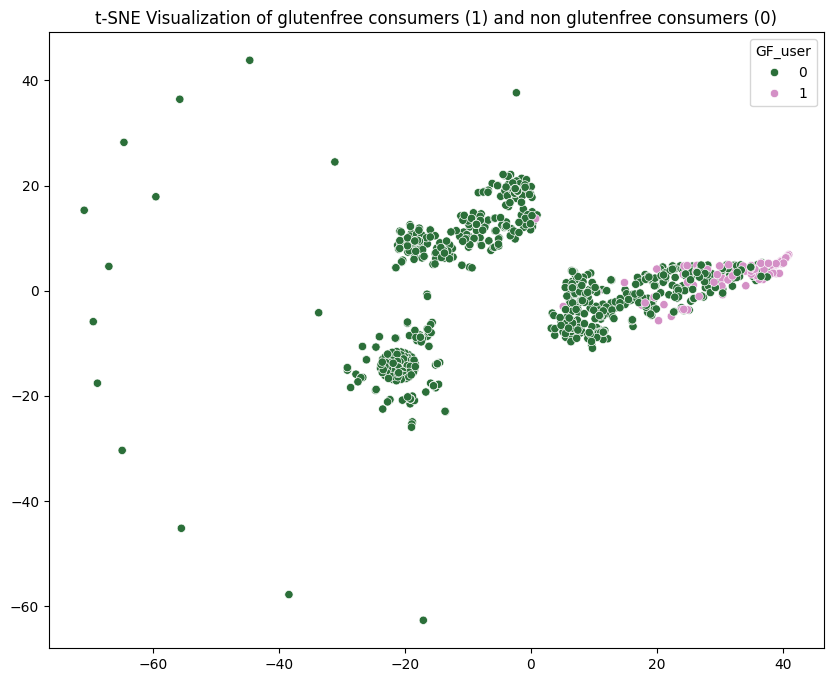

In [231]:
# Apply again  t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(bag_word.drop(columns=['GF_user']))

# Visualize in which clusters glutenfree consumers are!
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=bag_word['GF_user'], palette='cubehelix')
plt.title('t-SNE Visualization of glutenfree consumers (1) and non glutenfree consumers (0)')
plt.show()


Glutenfree consumers are in the cluster number three!

In [221]:
bag_word[['Cluster','GF_user']]

,Cluster,GF_user
0,1,0
1,1,0
2,1,0
3,2,0
4,1,0
...,...,...
819,2,0
820,1,0
821,2,0
822,2,0


What percentage of glutenfree consumers are there in the cluster three?

In [229]:
print("Accuracy: ", ((bag_word['Cluster']==3) == bag_word['GF_user']).sum() / len(bag_word['GF_user']))

Accuracy:  0.8677184466019418


It is not 100%, but is is pretty interesting!
Gluten-free consumers use a distinct vocabulary when describing beer compared to conventional beer consumers, suggesting differences in linguistic culture and communication styles. This variation is intriguing, especially since gluten-free consumers evaluate both gluten-free and non-gluten-free beers simultaneously. It implies the existence of two distinct consumer groups with diverse linguistic cultures and communication approaches.


## English analysis

redo the same for english text!

In [ ]:
english=reduce[reduce['lang']=='en']